In [6]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

In [2]:
%matplotlib inline

In [13]:
hashtag_day = "06.04"
hashtag_id = '#neyinnesi'

In [41]:
tweet_df = pd.read_csv('data/tweet_data.csv')

In [7]:
word_vectors = KeyedVectors.load_word2vec_format('/home/kemal/Desktop/Workspace/Turkish-Word2Vec/trmodel_me', binary=True)

In [31]:
def create_vocabulary(corpus):
    pipe = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer())]).fit(corpus)
    
    words = pipe['count'].get_feature_names()

    idf = pipe['tfid'].idf_

    vocabulary = {}
    for pair in zip(list(words), list(idf)):
        vocabulary[pair[0]] = pair[1]
    
    return vocabulary

In [47]:
def calc_idf(df, n):
    return np.log((1 + n)/(1 + df)) + 1

def my_create_vocabulary(corpus):
    vocabulary = {}
    for row in corpus:
        lookup = []
        for word in row.split():
            if word not in lookup:
                if word in vocabulary:
                    vocabulary[word] += 1
                else:
                    vocabulary[word] = 1
            lookup.append(word)
    
    N = len(corpus)
    for key in vocabulary.keys():
        df = vocabulary[key]
        vocabulary[key] = calc_idf(df, N)
    
    return vocabulary
    

In [52]:
voc_idf_2 = create_vocabulary(tweet_df['processed_text'])
voc_idf = my_create_vocabulary(tweet_df['processed_text'])


In [53]:
voc_idf_2['hemen']
len(voc_idf_2.keys())

12399

In [54]:
voc_idf['hemen']
len(voc_idf.keys())

12423

In [35]:
tweet = "hemen hemen hergün sayı vermek ölmek tesadüf müdür"
tweet_words = tweet.split()
tweet_words.sort(key=lambda word: -1 * voc_idf[word])
print(tweet_words)

['tesadüf', 'hemen', 'hemen', 'müdür', 'hergün', 'ölmek', 'sayı', 'vermek']


In [65]:
tweet_vectors_all = []
for ii in range(0, len(tweet_df)):
    hashtag_row_id = tweet_df.iloc[ii]['hashtag_id']
    if hashtag_row_id != hashtag_id:
        continue
        
    processed_text = tweet_df.iloc[ii]['processed_text']
    
    tweet_words = processed_text.split()
    tweet_words.sort(key=lambda word: -1 * voc_idf[word])
    tweet_vectors = []
    for word in tweet_words[0: min(len(tweet_words), 9)]:
        if word in word_vectors:
            tweet_vectors.append(word_vectors.get_vector(word))
    tweet_vectors_all.append(tweet_vectors)

X_w2vec = []
for vecs in tweet_vectors_all:
    if len(vecs) == 0:
        X_w2vec.append(np.zeros(400))
    else:
        X_w2vec.append(np.mean(vecs, axis=0))

X_w2vec = np.array(X_w2vec)

X_w2vec.shape

(5237, 400)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X_w2vec)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5237 samples in 0.195s...
[t-SNE] Computed neighbors for 5237 samples in 21.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5237
[t-SNE] Computed conditional probabilities for sample 2000 / 5237
[t-SNE] Computed conditional probabilities for sample 3000 / 5237
[t-SNE] Computed conditional probabilities for sample 4000 / 5237
[t-SNE] Computed conditional probabilities for sample 5000 / 5237
[t-SNE] Computed conditional probabilities for sample 5237 / 5237
[t-SNE] Mean sigma: 2.355437
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.507889
[t-SNE] KL divergence after 1000 iterations: 2.200309


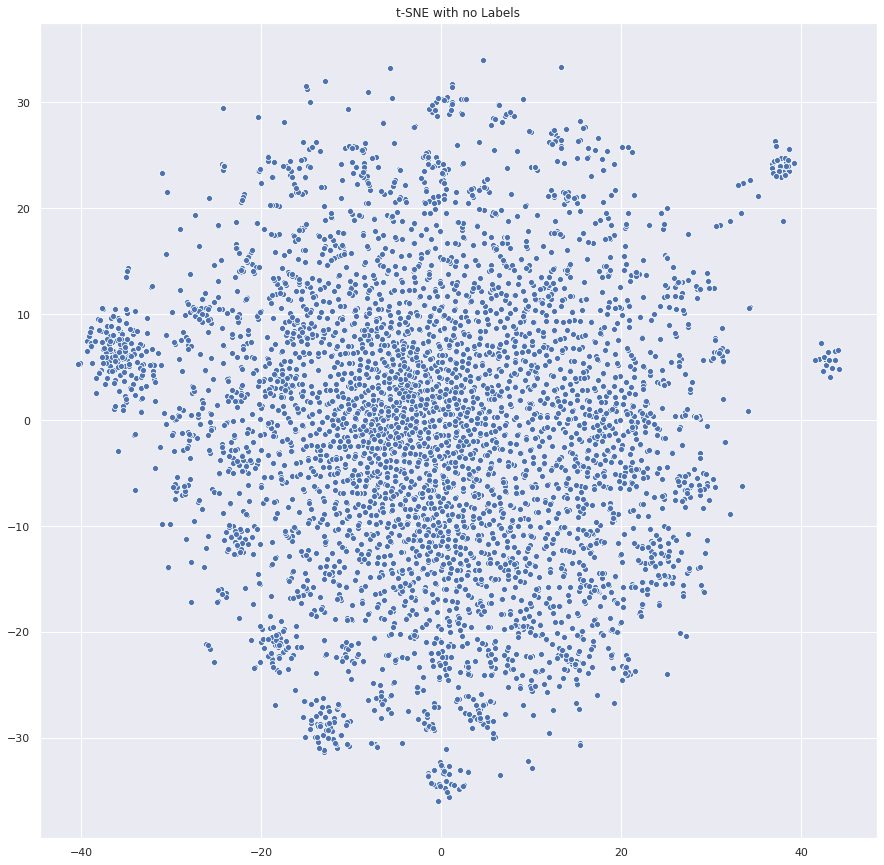

In [67]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_word_vec_{}_max_9.png".format(hashtag_day))
plt.show()

In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_reduced_pca = pca.fit_transform(X_w2vec)
X_reduced_pca .shape

(5237, 2)

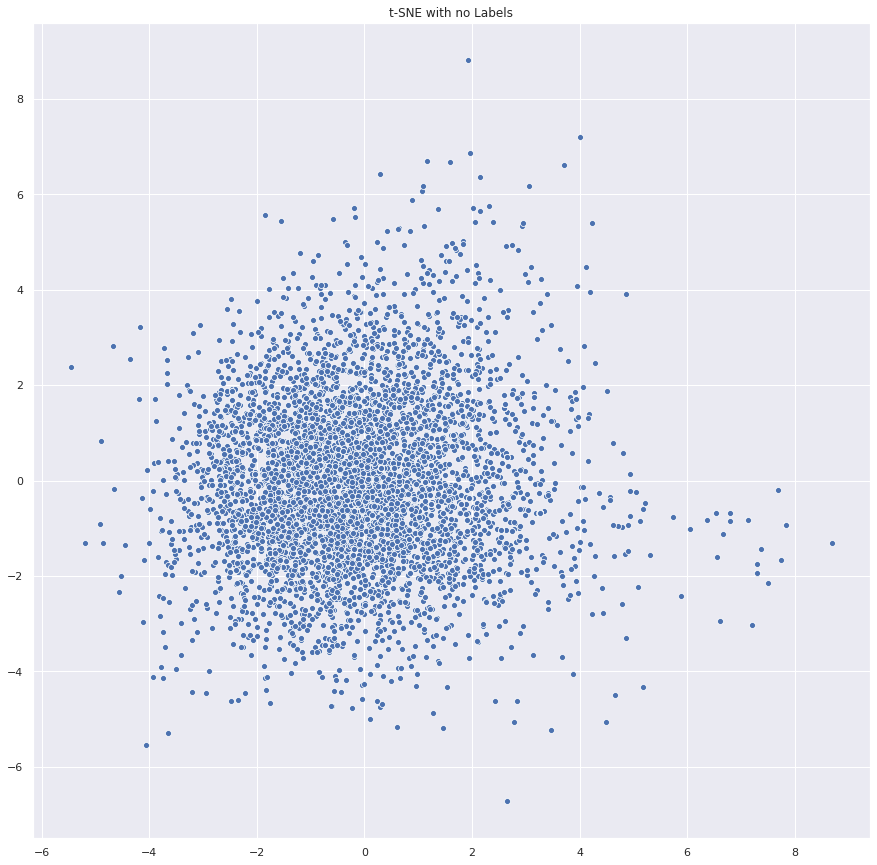

In [69]:
sns.scatterplot(X_reduced_pca[:,0], X_reduced_pca[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_word_vec_{}_pca.png".format(hashtag_day))
plt.show()